<a href="https://colab.research.google.com/github/vmokashi01/NYC_Housing_Exploration/blob/master/NYC_Housing_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d new-york-city/nyc-property-sales

nyc-property-sales.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip

Archive:  nyc-property-sales.zip
replace nyc-rolling-sales.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nyc-rolling-sales.csv   


# Preprocessing
## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("nyc-rolling-sales.csv")
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


## 2. Data Cleanup

In [ ]:
del df['Unnamed: 0'] #some sort of indexing
del df['EASE-MENT'] #empty column
df = df.drop_duplicates(keep='last')
df = df.replace(' -  ', np.nan)
df = df.replace(' ', np.nan)

In [ ]:
df['SALE PRICE'] = df['SALE PRICE'].fillna(0).astype('int')
df['SALE PRICE'].describe()

count    8.378300e+04
mean     1.064009e+06
std      1.042963e+07
min      0.000000e+00
25%      0.000000e+00
50%      4.200000e+05
75%      8.350000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83783 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         83783 non-null  int64 
 1   NEIGHBORHOOD                    83783 non-null  object
 2   BUILDING CLASS CATEGORY         83783 non-null  object
 3   TAX CLASS AT PRESENT            83045 non-null  object
 4   BLOCK                           83783 non-null  int64 
 5   LOT                             83783 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83045 non-null  object
 7   ADDRESS                         83783 non-null  object
 8   APARTMENT NUMBER                18849 non-null  object
 9   ZIP CODE                        83783 non-null  int64 
 10  RESIDENTIAL UNITS               83783 non-null  int64 
 11  COMMERCIAL UNITS                83783 non-null  int64 
 12  TOTAL UNITS                     83783 non-null

In [ ]:
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83783 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         83783 non-null  category      
 1   NEIGHBORHOOD                    83783 non-null  object        
 2   BUILDING CLASS CATEGORY         83783 non-null  object        
 3   TAX CLASS AT PRESENT            83045 non-null  category      
 4   BLOCK                           83783 non-null  int64         
 5   LOT                             83783 non-null  int64         
 6   BUILDING CLASS AT PRESENT       83045 non-null  object        
 7   ADDRESS                         83783 non-null  object        
 8   APARTMENT NUMBER                18849 non-null  object        
 9   ZIP CODE                        83783 non-null  int64         
 10  RESIDENTIAL UNITS               83783 non-null  int64         
 11  CO

## 3. Data Exploration

In [ ]:
df.shape

(83783, 20)

In [ ]:
df.columns[df.isnull().any()]

Index(['TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET'],
      dtype='object')

In [ ]:
df = df.dropna(subset=['LAND SQUARE FEET', 'GROSS SQUARE FEET'])
df.shape

(56393, 20)

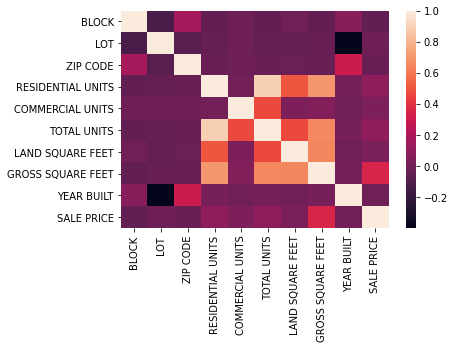

In [ ]:
corr = df.corr()
sns.heatmap(corr)

In [ ]:
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.354827
TOTAL UNITS          0.108023
RESIDENTIAL UNITS    0.099225
COMMERCIAL UNITS     0.044851
LAND SQUARE FEET     0.034702
YEAR BUILT           0.004262
LOT                 -0.009707
ZIP CODE            -0.020861
BLOCK               -0.047522
Name: SALE PRICE, dtype: float64

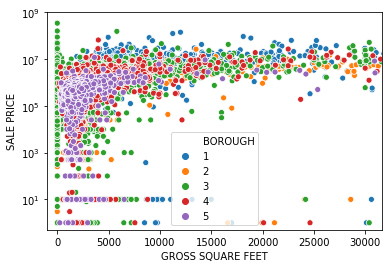

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df, hue='BOROUGH')
ax.set_xlim([-10**3, 10**4.5])
ax.set_ylim([.5, 10**9])
ax.set_yscale("log")
plt.show()

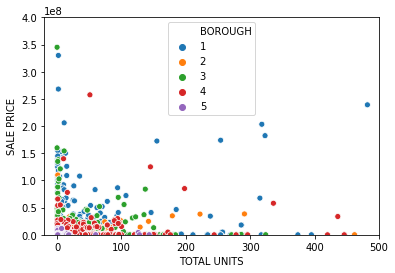

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x='TOTAL UNITS', y='SALE PRICE', data=df, hue='BOROUGH')
ax.set_xlim([-20, 500])
ax.set_ylim([-1000, 0.4*(10**9)])
ax.set_yscale("linear")
plt.show()

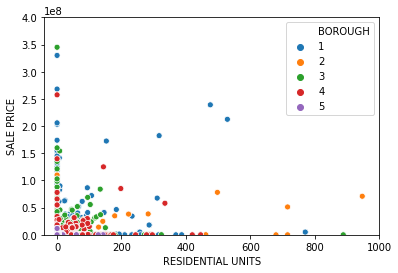

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=df, hue='BOROUGH')
ax.set_xlim([-40, 1000])
ax.set_ylim([-1000, 0.4*(10**9)])
ax.set_yscale("linear")
plt.show()

### Exploring Sale Price


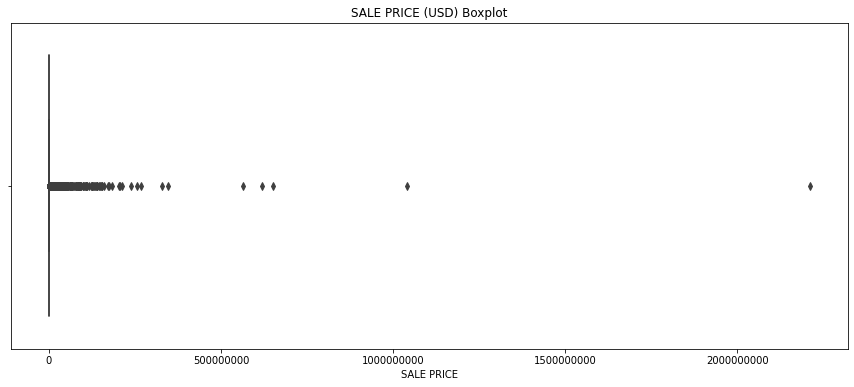

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='SALE PRICE', data=df)
plt.ticklabel_format(style='plain', axis='x')
plt.title('SALE PRICE (USD) Boxplot')
plt.show()

In [ ]:
df = df[(df['SALE PRICE'] > 1000) & (df['SALE PRICE'] < 5000000)] #removing outliers
df.shape

(35745, 20)

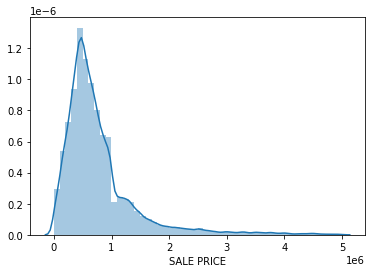

In [ ]:
sns.distplot(df['SALE PRICE'])

In [ ]:
df['SALE PRICE'].skew()
#heavily skewed right

2.6030685587873763

### Exploring Gross & Land Square Feet

Text(0.5, 1.0, 'GROSS SQUARE FEET Boxplot')

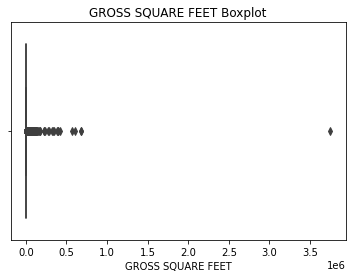

In [ ]:
sns.boxplot(x='GROSS SQUARE FEET', data=df)
plt.title('GROSS SQUARE FEET Boxplot')

Text(0.5, 1.0, 'LAND SQUARE FEET Boxplot')

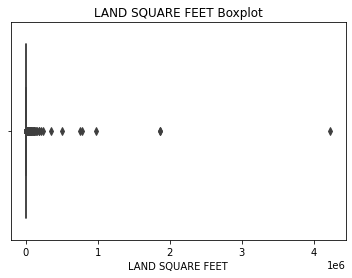

In [ ]:
sns.boxplot(x='LAND SQUARE FEET', data=df)
plt.title('LAND SQUARE FEET Boxplot')

In [ ]:
df = df[df['GROSS SQUARE FEET'] < 12500]
df = df[df['LAND SQUARE FEET'] < 20000]
#df.shape()

Text(0.5, 1.0, 'GROSS SQUARE FEET Scatterplot')

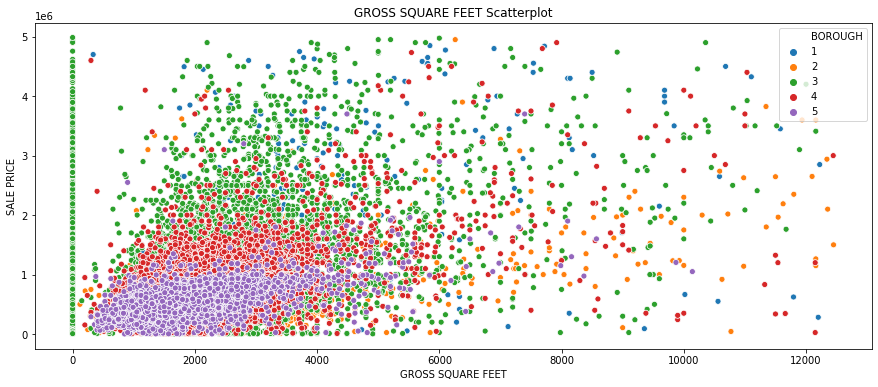

In [ ]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df, hue='BOROUGH')
plt.title('GROSS SQUARE FEET Scatterplot')

Text(0.5, 1.0, 'LAND SQUARE FEET Scatterplot')

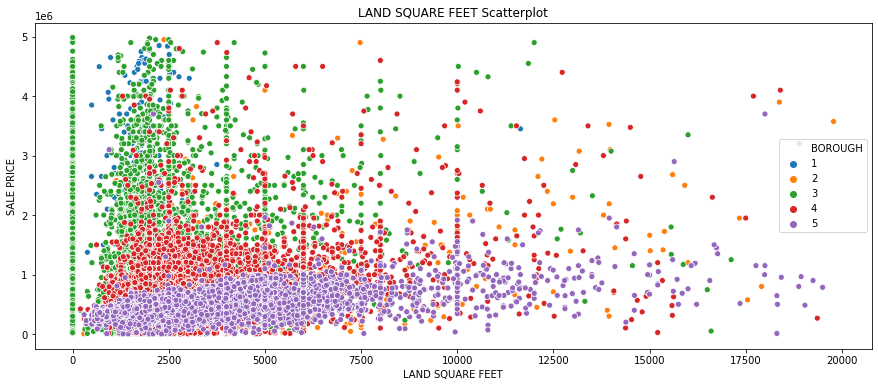

In [ ]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='LAND SQUARE FEET', y='SALE PRICE', data=df, hue='BOROUGH')
plt.title('LAND SQUARE FEET Scatterplot')

### Exploring Residential, Commercial, and Total Units

Text(0.5, 1.0, 'TOTAL UNITS Scatterplot')

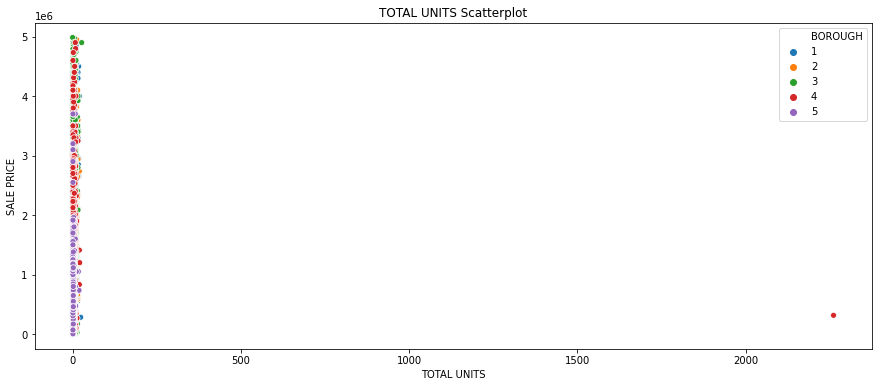

In [ ]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='TOTAL UNITS', y='SALE PRICE', data=df, hue='BOROUGH')
plt.title('TOTAL UNITS Scatterplot')

In [ ]:
df = df[df['TOTAL UNITS'] > 0] 
df = df[df['TOTAL UNITS'] < 500]

Text(0.5, 1.0, 'SALE PRICE by TOTAL UNITS')

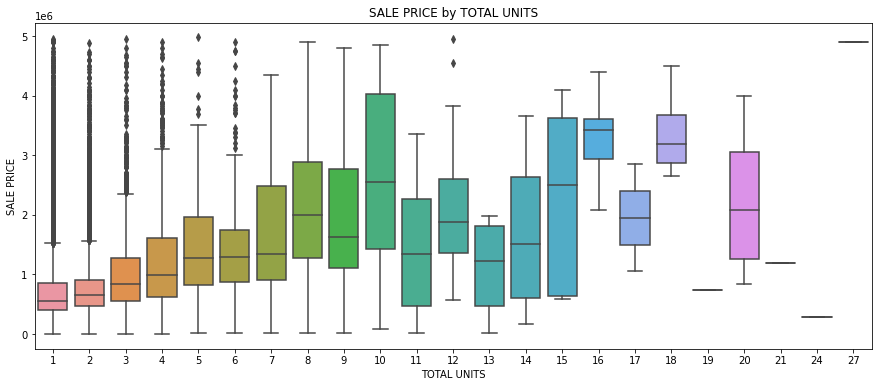

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=df)
plt.title('SALE PRICE by TOTAL UNITS')

Text(0.5, 1.0, 'SALE PRICE by COMMERCIAL UNITS')

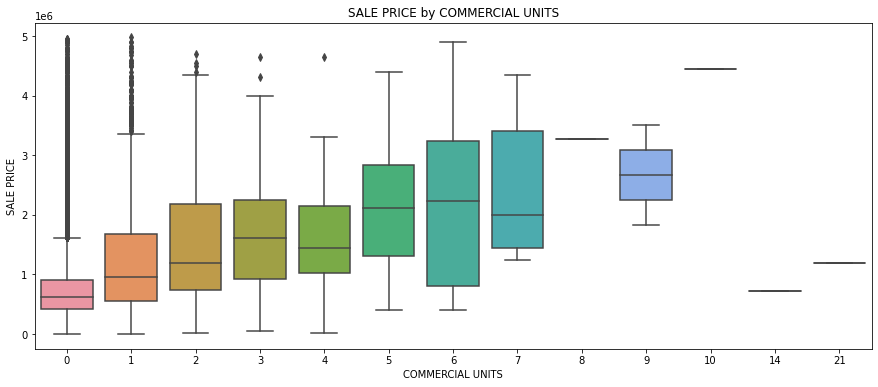

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=df)
plt.title('SALE PRICE by COMMERCIAL UNITS')

Text(0.5, 1.0, 'SALE PRICE by RESIDENTIAL UNITS')

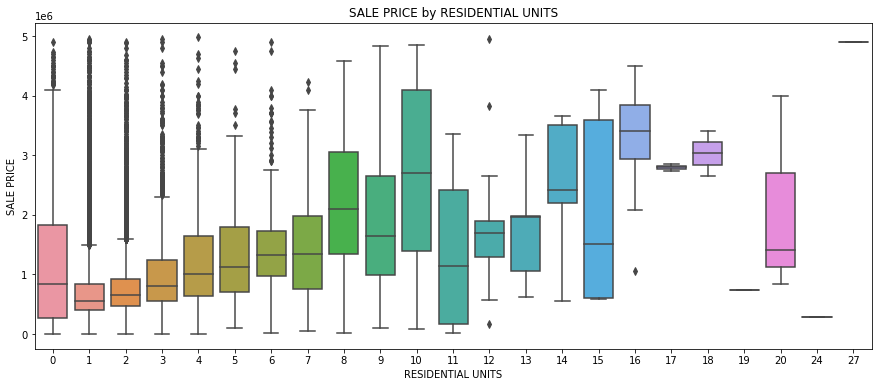

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=df)
plt.title('SALE PRICE by RESIDENTIAL UNITS')

### Exploring Categorical Variables

In [ ]:
cat_df = df.select_dtypes(exclude=[np.number])
cat_df.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
count,31372.0,31372,31372,31372,31372,31372,4600,31372.0,31372,31372
unique,5.0,237,38,9,108,28197,1203,3.0,109,327
top,3.0,BEDFORD STUYVESANT,01 ONE FAMILY DWELLINGS,1,A1,429 KENT AVENUE,4,1.0,A1,2017-02-28 00:00:00
freq,12010.0,799,12505,24562,4698,156,165,25090.0,4693,209
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-31 00:00:00


#### Borough & Neighbourhood

In [ ]:
pivot_neighbourhood = df.pivot_table(index = ['BOROUGH', 'NEIGHBORHOOD'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_neighbourhood

SALE PRICE
BOROUGH NEIGHBORHOOD                   
1       ALPHABET CITY      3.775822e+06
        CHELSEA            1.783000e+06
        CHINATOWN          3.350000e+06
        CLINTON            3.900000e+06
        EAST VILLAGE       3.850000e+06
...                                 ...
5       TRAVIS             4.121130e+05
        WEST NEW BRIGHTON  4.418415e+05
        WESTERLEIGH        5.462746e+05
        WILLOWBROOK        6.283109e+05
        WOODROW            5.511686e+05

[238 rows x 1 columns]

In [ ]:
pivot_borough = df.pivot_table(index = ['BOROUGH'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_borough

,SALE PRICE
BOROUGH,
1,2.346410e+06
2,5.056181e+05
3,1.045529e+06
4,7.102257e+05
5,5.169854e+05


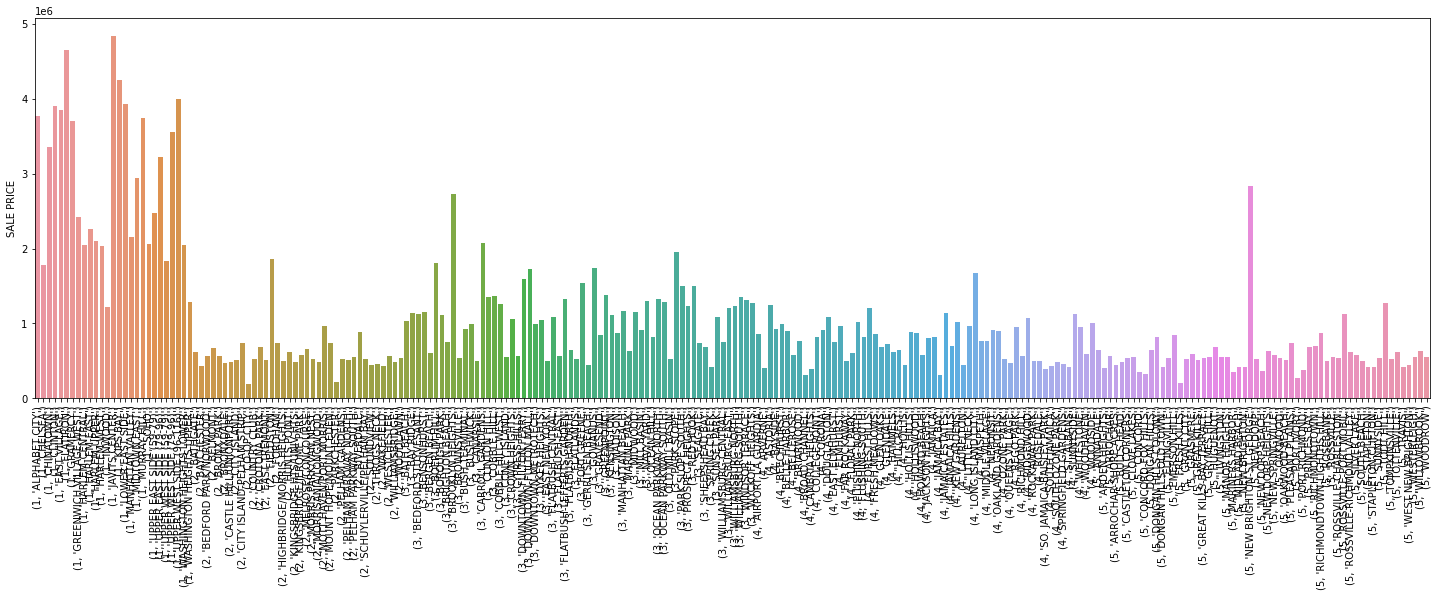

In [ ]:
plt.figure(figsize=(25,7))
plt.xticks(rotation='vertical')
sns.barplot(x=pivot_neighbourhood.index, y='SALE PRICE', data = pivot_neighbourhood)

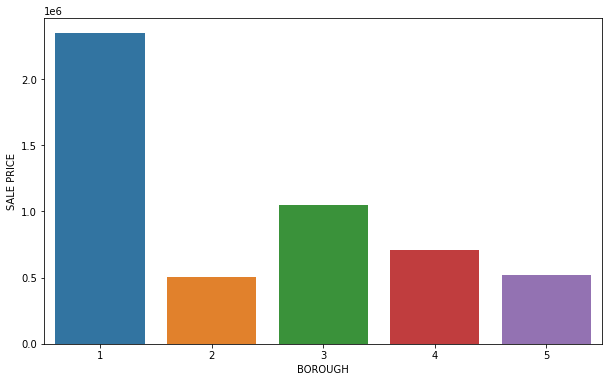

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=pivot_borough.index, y='SALE PRICE', data = pivot_borough)

#### Building Class Category

In [ ]:
pivot_build_cat = df.pivot_table(index = ['BUILDING CLASS CATEGORY'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_build_cat

,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,6.147992e+05
02 TWO FAMILY DWELLINGS,7.630452e+05
03 THREE FAMILY DWELLINGS,9.526005e+05
04 TAX CLASS 1 CONDOS,6.888221e+05
05 TAX CLASS 1 VACANT LAND,1.276861e+06
06 TAX CLASS 1 - OTHER,5.384830e+05
07 RENTALS - WALKUP APARTMENTS,1.472926e+06
08 RENTALS - ELEVATOR APARTMENTS,3.869286e+06
09 COOPS - WALKUP APARTMENTS,1.860000e+05


In [ ]:
pivot_build_cat_pres = df.pivot_table(index = ['BUILDING CLASS AT PRESENT'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_build_cat_pres

,SALE PRICE
BUILDING CLASS AT PRESENT,
A0,6.592321e+05
A1,6.282158e+05
A2,5.573269e+05
A3,1.398823e+06
A4,1.976645e+06
...,...
W4,2.200000e+06
W8,9.750000e+05
W9,6.870000e+05


In [ ]:
pivot_build_cat_sale = df.pivot_table(index = ['BUILDING CLASS AT TIME OF SALE'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_build_cat_sale

,SALE PRICE
BUILDING CLASS AT TIME OF SALE,
A0,6.699085e+05
A1,6.282866e+05
A2,5.572759e+05
A3,1.398981e+06
A4,1.960574e+06
...,...
W4,2.200000e+06
W8,9.750000e+05
W9,6.870000e+05


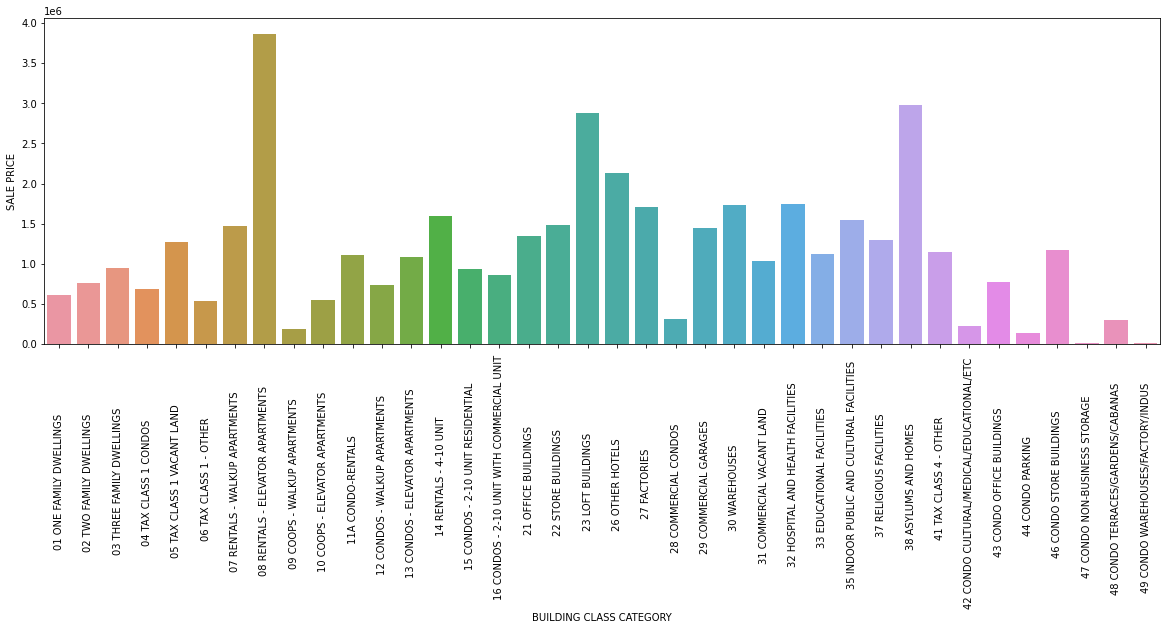

In [ ]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
sns.barplot(x=pivot_build_cat.index, y='SALE PRICE', data = pivot_build_cat)

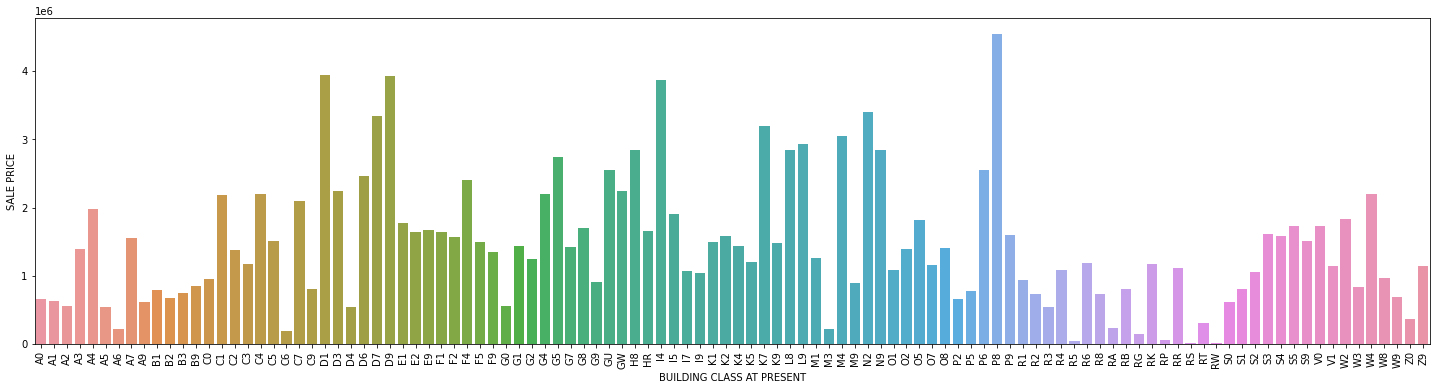

In [ ]:
plt.figure(figsize=(25,6))
plt.xticks(rotation='vertical')
sns.barplot(x=pivot_build_cat_pres.index, y='SALE PRICE', data = pivot_build_cat_pres)

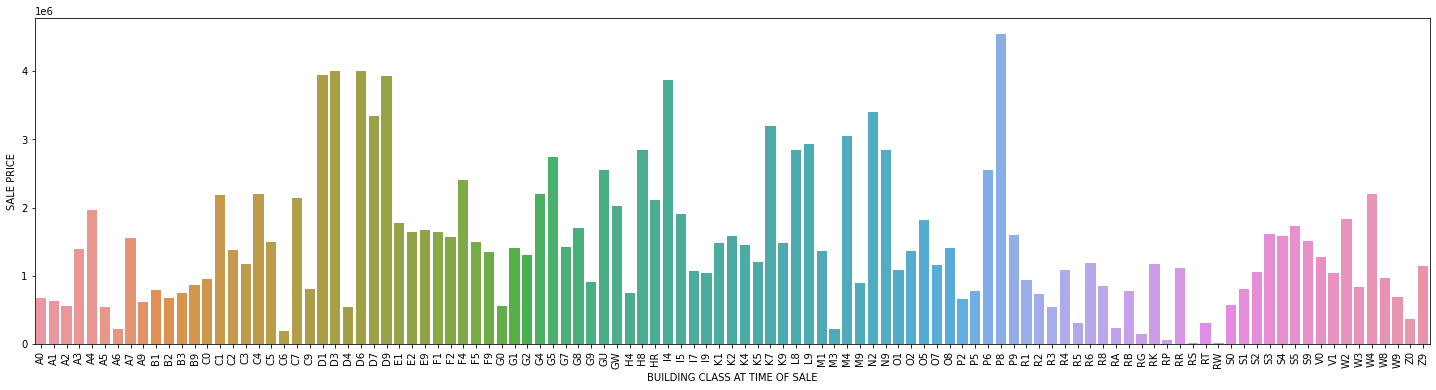

In [ ]:
plt.figure(figsize=(25,6))
plt.xticks(rotation='vertical')
sns.barplot(x=pivot_build_cat_sale.index, y='SALE PRICE', data = pivot_build_cat_sale)

In [ ]:
# Create a pivot for the difference and plot the differences!

#### Tax Class

In [ ]:
pivot_tax_pres = df.pivot_table(index = ['TAX CLASS AT PRESENT'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_tax_pres

,SALE PRICE
TAX CLASS AT PRESENT,
1,7.054538e+05
1A,5.488291e+05
1B,1.730416e+06
1C,1.184937e+06
2,1.071700e+06
2A,1.317165e+06
2B,2.022591e+06
2C,9.275116e+05
4,1.222518e+06


In [ ]:
pivot_tax_sale = df.pivot_table(index = ['TAX CLASS AT TIME OF SALE'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_tax_sale

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,7.053669e+05
2,1.165300e+06
4,1.217599e+06


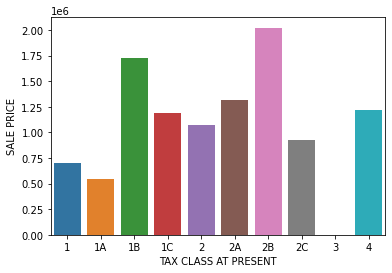

In [ ]:
sns.barplot(x=pivot_tax_pres.index, y='SALE PRICE', data = pivot_tax_pres)

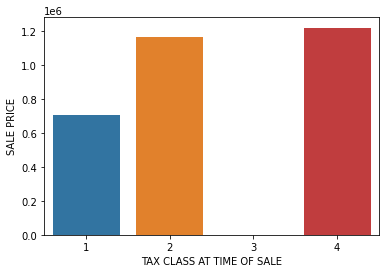

In [ ]:
sns.barplot(x=pivot_tax_sale.index, y='SALE PRICE', data = pivot_tax_sale)

#### Sale Date

In [ ]:
pivot_date = df.pivot_table(index = ['SALE DATE'], values = 'SALE PRICE', aggfunc=np.mean)
pivot_date

,SALE PRICE
SALE DATE,
2016-09-01,755447.792593
2016-09-02,683057.506329
2016-09-05,875000.000000
2016-09-06,916776.776596
2016-09-07,781748.359712
...,...
2017-08-26,226726.000000
2017-08-28,831366.482143
2017-08-29,965158.481481


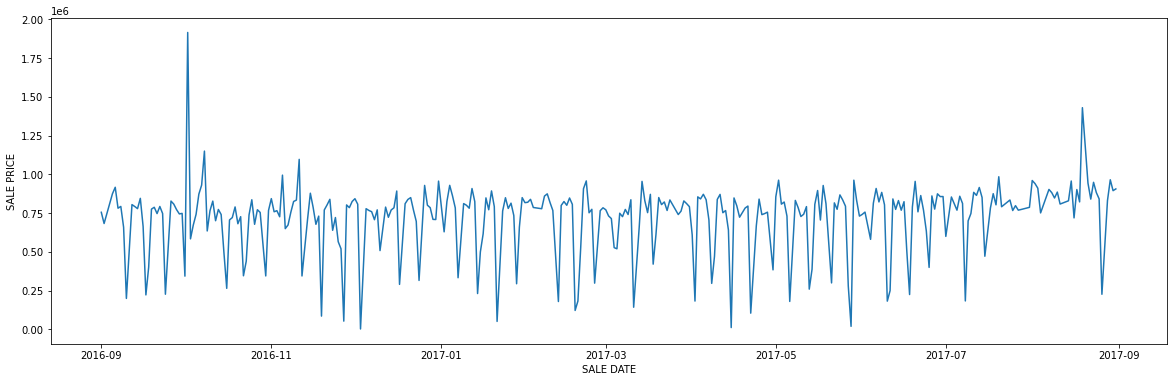

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=pivot_date.index, y='SALE PRICE', data = pivot_date)

# Modelling


In [ ]:
#normalise numerical variables
#one-hot encoding for the categorical variables

In [ ]:
del df['ADDRESS']
del df['APARTMENT NUMBER']
del df['SALE DATE']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31372 entries, 3 to 84547
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         31372 non-null  category
 1   NEIGHBORHOOD                    31372 non-null  object  
 2   BUILDING CLASS CATEGORY         31372 non-null  object  
 3   TAX CLASS AT PRESENT            31372 non-null  category
 4   BLOCK                           31372 non-null  int64   
 5   LOT                             31372 non-null  int64   
 6   BUILDING CLASS AT PRESENT       31372 non-null  object  
 7   ZIP CODE                        31372 non-null  int64   
 8   RESIDENTIAL UNITS               31372 non-null  int64   
 9   COMMERCIAL UNITS                31372 non-null  int64   
 10  TOTAL UNITS                     31372 non-null  int64   
 11  LAND SQUARE FEET                31372 non-null  float64 
 12  GROSS SQUARE FEET 

In [ ]:
num_data = df.select_dtypes(include=[np.number])
num_data.columns

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE'],
      dtype='object')

##Log Transforming and Scaling the Data

In [ ]:
#determine which features are skewed
skewed_ft = df[num_data.columns].apply(lambda x: skew(x.dropna().astype(float))) #skew value of numerical features
skewed_ft = skewed_ft[skewed_ft > 0.75] #threshold skew value of 0.75 for moderate to highly skewed features
skewed_ft = skewed_ft.index

In [ ]:
df[skewed_ft] = np.log1p(df[skewed_ft]) #log(x+1) transform (normalizes features and accounts for zeros)

In [ ]:
#scaling features
scaler = StandardScaler()
scaled_ft = scaler.fit_transform(df[num_data.columns])

In [ ]:
#replacing df numerical column data with scaled data
for i, col in enumerate(num_data.columns):
       df[col] = scaled_ft[:,i]

## One-Hot Encoding Categorical Variables

In [ ]:
cat_features = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE', 'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE']

In [ ]:
one_hot_enc = pd.get_dummies(df[cat_features])
one_hot_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31372 entries, 3 to 84547
Columns: 511 entries, BOROUGH_1 to TAX CLASS AT TIME OF SALE_4
dtypes: uint8(511)
memory usage: 16.8 MB


In [ ]:
fin_df = df.drop(cat_features, axis=1)
fin_df = pd.concat([fin_df, one_hot_enc], axis=1)

## Train/Test Split

In [ ]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31372 entries, 3 to 84547
Columns: 521 entries, BLOCK to TAX CLASS AT TIME OF SALE_4
dtypes: float64(10), uint8(511)
memory usage: 19.2 MB


In [ ]:
Y_df = fin_df['SALE PRICE']
X_df = fin_df.drop('SALE PRICE', axis=1)

X_df.shape , Y_df.shape

((31372, 520), (31372,))

In [ ]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_df , Y_df , test_size = 0.2 , random_state =42)

In [ ]:
X_train.shape , Y_train.shape

((25097, 520), (25097,))

In [ ]:
X_test.shape , Y_test.shape

((6275, 520), (6275,))

In [ ]:
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(y_test, y_pred))

##1. Linear Regression


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_pred_lr = lin_reg.predict(X_test)
rmse(Y_test, Y_pred_lr)

470092957.4961588

In [ ]:
print('R2: ', r2_score(Y_test, Y_pred_lr)) #why is RMSE so high and r2 negative?

R2:  -2.1724875194485517e+17



##2. Ridge Regression


In [ ]:
ridge_reg = RidgeCV(alphas = np.logspace(-3,1,50))
ridge_reg.fit(X_train, Y_train)
Y_pred_ridge = ridge_reg.predict(X_test)
rmse(Y_test, Y_pred_ridge)

0.7363182824911723

In [ ]:
print('Alpha: ', ridge_reg.alpha_)
print('R2: ', r2_score(Y_test, Y_pred_ridge))

Alpha:  3.906939937054613
R2:  0.46700765934707444


##3. Lasso Regression

In [ ]:
lasso_reg = LassoCV(alphas = np.logspace(-3,1,50))
lasso_reg.fit(X_train, Y_train)
Y_pred_lasso = lasso_reg.predict(X_test)
rmse(Y_test, Y_pred_lasso)

0.7631741478572412

In [ ]:
print('Alpha: ', lasso_reg.alpha_)
print('R2: ', r2_score(Y_test, Y_pred_lasso))

Alpha:  0.001
R2:  0.42741877811855267


##4. Elastic Net Regression

In [ ]:
elastic_reg = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99], alphas = np.logspace(-3,1,50))
elastic_reg.fit(X_train, Y_train)
Y_pred_elastic = elastic_reg.predict(X_test)
rmse(Y_test, Y_pred_elastic)

0.742886643549123

In [ ]:
print('Alpha: ', elastic_reg.alpha_)
print('L1 Ratio: ', elastic_reg.l1_ratio_)
print('R2: ', r2_score(Y_test, Y_pred_elastic))

Alpha:  0.001
L1 Ratio:  0.1
R2:  0.45745608056401754


##5. Random Forest Regression

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, Y_train)
Y_pred_rf = rf_reg.predict(X_test)
rmse(Y_test, Y_pred_rf)

0.7135496327817273

In [ ]:
print('R2: ', r2_score(Y_test, Y_pred_rf))

R2:  0.49946070905867357
